In [1]:
import cvxpy as cv

In [2]:
from collections import defaultdict
import operator
from functools import reduce

In [3]:
import sympy as sp
from sympy.parsing.latex import parse_latex
import numpy as np
import pandas as pd

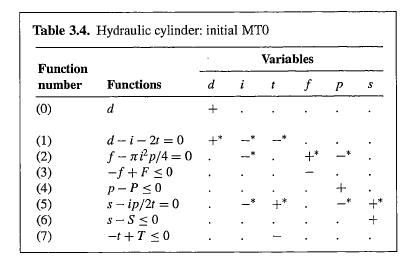

objective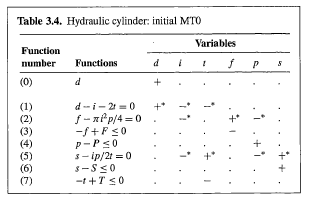

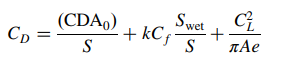

In [4]:
from compute import Var, eqvar, get_unit
from inputresolver import idx_eqlist, getallvars

In [5]:
d = Var('d')
i = Var('i')
t = Var('t')
s = Var('s')
f = Var('f')
p = Var('p')
F = Var('F', never_output=True)
P = Var('P', never_output=True)
S = Var('S', never_output=True)
T = Var('T', never_output=True)

In [6]:
eqlist = [d, d-i-2*t, f-np.pi*i**2*p/4, -f+F, p-P, s-i*p/(2*t), s-S, -t+T]
eqs = idx_eqlist(eqlist)

In [7]:
eqs

{0: d,
 1: d - i - 2*t,
 2: f - 0.785398163397448*i**2*p,
 3: F - f,
 4: -P + p,
 5: -i*p/(2*t) + s,
 6: -S + s,
 7: T - t}

## Woody's example

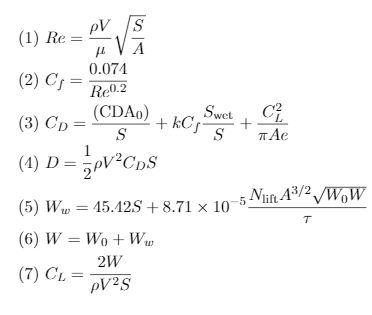

In [8]:
rho = Var('rho', 1.23, 'kg/m^3', never_output=True)
mu = Var('mu', 1.78e-5, 'kg/m/s', never_output=True)
SwetS = Var('SwetS', 2.05, never_output=True)
k = Var('k', 1.2, never_output=True)
t = Var('t', 0.12, 'm', never_output=True)
e = Var('e', 0.96, never_output=True)
N = Var('N', 2.5, never_output=True)
CDA = Var('CDA', 0.0306, 'm^2', never_output=True)
W0 = Var('W0', 4940, 'N', never_output=True)
rhoS = Var('rhoS', 45.42, 'N/m^2', never_output=True)

A = Var('A')
V = Var('V', unit='m/s')
S = Var('S', unit='m^2')
Re, f1 = eqvar('Re', rho*V/mu*(S/A)**(1/2))
Cf, f2 = eqvar('Cf', 0.074/Re**0.2, unit='', forceunit=True)
CL = Var('CL')
CD, f3 = eqvar('CD', CDA/S+k*Cf*SwetS+CL**2/(np.pi*A*e))
D, f4 = eqvar('D', 0.5*rho*V**2*CD*S)
W = Var('W', unit='N')
Ww, f5 = eqvar('Ww', rhoS*S+8.71e-5*N/t*A**(3/2)*S**(1/2)*(W0*W)**(1/2))
f6 = (W, W0+Ww)
f7 = (CL, 2*W/(rho*V**2*S))
eqlist = [D, f1[1]/Re, f2[1]/Cf, f3[1]/CD, f4[1]/D, f5[1]/Ww, f6[1]/W, f7[1]/CL]
eqs = idx_eqlist(eqlist)

In [9]:
eqs

{0: D,
 1: V*rho*(S/A)**0.5/(Re*mu),
 2: 0.074*Re**(-0.2)/Cf,
 3: (CDA/S + Cf*SwetS*k + 0.318309886183791*CL**2/(A*e))/CD,
 4: 0.5*CD*S*V**2*rho/D,
 5: (8.71e-5*A**1.5*N*S**0.5*(W*W0)**0.5/t + S*rhoS)/Ww,
 6: (W0 + Ww)/W,
 7: 2*W/(CL*S*V**2*rho)}

In [10]:
vrs = set()
for right in eqs.values():
    vrs = vrs.union(right.free_symbols)
vrtrue = [vr for vr in vrs if not vr.never_output]

In [11]:
vrtrue

[V, S, D, CL, Ww, W, CD, A, Cf, Re]

Use cvxpy to check for non-negativity

In [12]:
signlookup = {
    'NONPOSITIVE': '-',
    'NONNEGATIVE': '+',
    True: '+',
    False: '-'
}

In [13]:
def get_monotonicites(expr):
    out = {}
    expr_symb = [symb for symb in expr.free_symbols]
    cvvar = [cv.Variable(name=s.name, pos=True) for s in expr_symb]
    for s in expr_symb:
        if not s.never_output:
            dexpr = sp.diff(expr, s)
            f = sp.lambdify(expr_symb, dexpr, {'sqrt': cv.sqrt}) #make sure we have tests for other math functions
            cvexpr = f(*cvvar)
            out[s] = signlookup.get(cvexpr.sign, 'n') if hasattr(cvexpr, 'sign') else signlookup[cvexpr>0]
            #print(s, cvexpr, cvexpr.sign if hasattr(cvexpr, 'sign') else cvexpr>0)
    return out

In [14]:
#get_monotonicites(expr)

In [15]:
data = {key: get_monotonicites(var) for key,var in eqs.items()}
df = pd.DataFrame.from_dict(data, orient='index').fillna('.    ')
df.sort_index()

,D,A,V,S,Re,Cf,CD,CL,Ww,W
0,+,.,.,.,.,.,.,.,.,.
1,.,-,+,+,-,.,.,.,.,.
2,.,.,.,.,-,-,.,.,.,.
3,.,-,.,-,.,+,-,+,.,.
4,-,.,+,+,.,.,+,.,.,.
5,.,+,.,+,.,.,.,.,-,+
6,.,.,.,.,.,.,.,.,+,-
7,.,.,-,-,.,.,.,-,.,+


In [32]:
entries = edges.keys()
neq = len(eqs)
objective = {0}
posynomials = {3,5,6}
monomials = {1,2,4,7}

In [55]:
edges = {}
signtable = {'+': True, '-':False, 'n':None}
eqs_per_var = {var: 0 for var in vrtrue}
vars_per_eq = {eq: list() for eq in range(neq)}
eqs_per_var_mono = {var: 0 for var in vrtrue}
eqs_per_var_posy = {var: list() for var in vrtrue}
for key,var in data.items():
    for elt, sign in var.items():
        edges[(key, elt)]= signtable[sign]
        eqs_per_var[elt]+=1
        vars_per_eq[key].append(elt)
        if (key in monomials) or (key in objective):
            eqs_per_var_mono[elt]+=1
        else:
            eqs_per_var_posy[elt]+=[key]

In [73]:
eqs_per_var_mono

{V: 3, S: 3, D: 2, CL: 1, Ww: 0, W: 1, CD: 1, A: 1, Cf: 1, Re: 2}

In [20]:
eqs_per_var_posy

{V: [],
 S: [3, 5],
 D: [],
 CL: [3],
 Ww: [5, 6],
 W: [5, 6],
 CD: [3],
 A: [3, 5],
 Cf: [3],
 Re: []}

In [21]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
from networkx.algorithms import bipartite

In [22]:
vrtrue

[V, S, D, CL, Ww, W, CD, A, Cf, Re]

In [23]:
eqs_per_var

{V: 3, S: 5, D: 2, CL: 2, Ww: 2, W: 3, CD: 2, A: 3, Cf: 2, Re: 2}

In [24]:
vrtrue

[V, S, D, CL, Ww, W, CD, A, Cf, Re]

In [75]:
eqs_per_var_posy

{V: [],
 S: [3, 5],
 D: [],
 CL: [3],
 Ww: [5, 6],
 W: [5, 6],
 CD: [3],
 A: [3, 5],
 Cf: [3],
 Re: []}

In [69]:
m = gp.Model('monotonicityassign')
m.setParam('OutputFlag', False )
l = m.addVars(neq, name="l", vtype=GRB.BINARY)  #one less because objective does not count
x = m.addVars(entries, name="x", vtype=GRB.BINARY)
#m.addConstrs((x[0, j]==edges[0,j] for j in vars_per_eq[0])) # objective is fixed
m.addConstrs((x.sum('*',j) <= -1+eqs_per_var_mono[j]+reduce(lambda a,b: a+l[b], eqs_per_var_posy[j], 0) for j in vrtrue), name='notallpositive')
m.addConstrs((x.sum('*',j) >= 1 for j in vrtrue), name='notallnegative')
for (key,val), sgn in edges.items():
    if key in monomials:
        if sgn:
            m.addConstr(l[key] == x[key,val])
        else:
            m.addConstr(l[key] == 1-x[key,val])
    elif key in posynomials:
        m.addConstr(x[key,val] == l[key]*sgn)
    else:
        m.addConstr(x[key,val]==int(sgn))
#for elt in posynomials:
m.addConstr(sum([l[elt] for elt in posynomials]) <= 2) 
m.setObjective(0, GRB.MINIMIZE)

In [70]:
#m.write('ma.lp')

In [71]:
m.optimize()

In [72]:
m.status

3

In [48]:
[l[i].x for i in range(neq) if i not in objective]

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [49]:
data_solved = defaultdict(dict)
for (r, j) in edges:
    data_solved[j][r] = signlookup[x[r,j].x>1e-6]

In [50]:
pd.DataFrame(data_solved).fillna('.    ').sort_index()

,D,A,V,S,Re,Cf,CD,CL,Ww,W
0,+,.,.,.,.,.,.,.,.,.
1,.,+,-,-,+,.,.,.,.,.
2,.,.,.,.,-,-,.,.,.,.
3,.,-,.,-,.,+,-,+,.,.
4,-,.,+,+,.,.,+,.,.,.
5,.,+,.,+,.,.,.,.,-,+
6,.,.,.,.,.,.,.,.,+,-
7,.,.,-,-,.,.,.,-,.,+


In [ ]:
data = {key: get_monotonicites(var) for key,var in eqs.items()}
df = pd.DataFrame.from_dict(data, orient='index').fillna('.    ')
df.sort_index()

In [86]:
from collections import defaultdict

In [87]:
assignment = []
varnames =vrtrue

In [88]:
for var in varnames:
    d = defaultdict(list)
    for val in g[var]:
        b = 'upbnding' if edges[val,var] else 'lowbnding' #x[val,var].x>1e-6
        d[str(b)].append(val)
    for key in ['upbnding', 'lowbnding']:
        if len(d[key]) == 1:
            assignment.append((d[key][0], var))

NameError: name 'g' is not defined

In [98]:
#assignment.append((5, 'p'))
assignment.append((2, 't'))

In [99]:
assignment

[(2, 'f'),
 (3, 'f'),
 (2, 'i'),
 (6, 's'),
 (5, 's'),
 (0, 'd'),
 (1, 'd'),
 (2, 'p'),
 (1, 't'),
 (2, 'f'),
 (3, 'f'),
 (5, 'p'),
 (2, 't')]

In [105]:
d = defaultdict(list)
for key,val in assignment:
    d[key].append(val)

In [107]:
dict(d)

{2: ['i', 'p', 'f'], 6: ['s'], 5: ['s'], 0: ['d'], 1: ['d', 't'], 3: ['f']}

For GP check that there is no empty row on equalities

In [100]:
from representations import drawbipartite

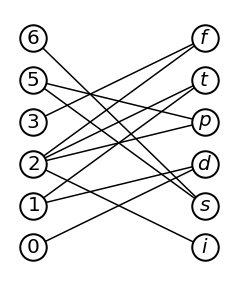

In [101]:
drawbipartite(nx.Graph(assignment))